## CIC-DDOS 2019 Dataset

## Table of contents:

1. [Importing libraries](#Libraries)
2. [Loading data](#Data)
3. [Statistical summaries](#Statistics)
4. [Exploratory Data Analysis](#EDA)
5. [Preprocess dataset](#Preprocess)
6. [Model Building](#Modelling)

<a name="Libraries"></a>
## 1. Importing libraries

In [1]:
import os
import warnings
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn import svm
import tensorflow as tf
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.svm import SVC, LinearSVC
pd.set_option('display.max_columns',None)
from tensorflow.keras import regularizers
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,BaggingClassifier, VotingClassifier

<a name="Data"></a>
## 2. Loading data

In [2]:
dfps_tr = []
dfps_ts = []
for dirname, _, filenames in os.walk(r'C:\Users\ADMIN\Documents\Networkdetection\DDOS2019'):
    for filename in filenames:
        if filename.endswith('-training.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps_tr.append(dfp)
            print(dfp)
        elif filename.endswith('-testing.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps_ts.append(dfp)
            print(dfp)
            

C:\Users\ADMIN\Documents\Networkdetection\DDOS2019\DNS-testing.parquet
C:\Users\ADMIN\Documents\Networkdetection\DDOS2019\LDAP-testing.parquet
C:\Users\ADMIN\Documents\Networkdetection\DDOS2019\LDAP-training.parquet
C:\Users\ADMIN\Documents\Networkdetection\DDOS2019\MSSQL-testing.parquet
C:\Users\ADMIN\Documents\Networkdetection\DDOS2019\MSSQL-training.parquet
C:\Users\ADMIN\Documents\Networkdetection\DDOS2019\NetBIOS-testing.parquet
C:\Users\ADMIN\Documents\Networkdetection\DDOS2019\NetBIOS-training.parquet
C:\Users\ADMIN\Documents\Networkdetection\DDOS2019\NTP-testing.parquet
C:\Users\ADMIN\Documents\Networkdetection\DDOS2019\Portmap-training.parquet
C:\Users\ADMIN\Documents\Networkdetection\DDOS2019\SNMP-testing.parquet
C:\Users\ADMIN\Documents\Networkdetection\DDOS2019\Syn-testing.parquet
C:\Users\ADMIN\Documents\Networkdetection\DDOS2019\Syn-training.parquet
C:\Users\ADMIN\Documents\Networkdetection\DDOS2019\TFTP-testing.parquet
C:\Users\ADMIN\Documents\Networkdetection\DDOS2019\U

A function was used to ease the iteration of the dataset which are in a parquet format ending with "-training.parquet" and "-testing.parquet". Then collection and storing of these file paths in two separate lists, dfps_tr and dfps_ts was done. Which further prints each file path to the console as it processes them.

In [3]:
df_train = pd.concat([pd.read_parquet(dfp) for dfp in dfps_tr], ignore_index=True)
df_test = pd.concat([pd.read_parquet(dfp) for dfp in dfps_ts], ignore_index=True)
df_train.shape, df_test.shape

((125170, 78), (306201, 78))

In [4]:
df_train.columns == df_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [5]:
target = 'Label'
print("TRAIN")
print(df_train.Label.value_counts())
print("TEST")
print(df_test.Label.value_counts())

TRAIN
Syn        48840
Benign     46427
UDP        18090
MSSQL       8523
LDAP        1906
Portmap      685
NetBIOS      644
UDPLag        55
Name: Label, dtype: int64
TEST
DrDoS_NTP        121368
TFTP              98917
Benign            51404
DrDoS_UDP         10420
UDP-lag            8872
DrDoS_MSSQL        6212
DrDoS_DNS          3669
DrDoS_SNMP         2717
DrDoS_LDAP         1440
DrDoS_NetBIOS       598
Syn                 533
WebDDoS              51
Name: Label, dtype: int64


In [6]:
df_train.Label.value_counts

<bound method IndexOpsMixin.value_counts of 0         NetBIOS
1            LDAP
2         NetBIOS
3            LDAP
4            LDAP
           ...   
125165     Benign
125166     Benign
125167     Benign
125168     Benign
125169     Benign
Name: Label, Length: 125170, dtype: object>

<a name="Statistics"></a>
## 3. Statistical summaries

### In this notebook the problem is treated as binary
The Label column typically offers the class and for some classes with multiple attacks it labels them individually.
In this notebook the first focus is the binary problem so we collapse the class label.

In [7]:
df_train['Label'] = df_train['Label'].astype('object')
df_train.loc[df_train['Label'] != 'Benign', 'Label'] = 1
df_train.loc[df_train['Label'] == 'Benign', 'Label'] = 0
print(df_train['Label'].value_counts())
df_train['Label'] = df_train['Label'].astype(dtype=np.int32)

1    78743
0    46427
Name: Label, dtype: int64


In [8]:
df_test['Label'] = df_test['Label'].astype('object')
df_test.loc[df_test['Label'] != 'Benign', 'Label'] = 1
df_test.loc[df_test['Label'] == 'Benign', 'Label'] = 0
print(df_test['Label'].value_counts())
df_test['Label'] = df_test['Label'].astype(dtype=np.int32)

1    254797
0     51404
Name: Label, dtype: int64


In [9]:
conts = list(df_train.columns.difference([target]).values)
len(conts)

77

In [10]:
df_train.groupby(target)['Bwd Packets/s'].value_counts(normalize=True).sort_values(ascending=False)
df_train

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Avg Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init Fwd Win Bytes,Init Bwd Win Bytes,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,17,49,2,0,458.0,0.0,229.0,229.0,229.0,0.0,0.0,0.0,0.0,0.0,9.346939e+06,4.081633e+04,49.000000,0.000000,49.0,49.0,49.0,49.0,0.0,49.0,49.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,16,0,4.081633e+04,0.000000,229.0,229.0,229.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,343.5,229.0,0.0,0,0,0,0,0,0,2,458,0,0,-1,-1,1,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2.000000e+06,1.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,2960,0,2.000000e+06,0.000000,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,1480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,17,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,0.0,0.0,0.0,0.0,4.580000e+08,2.000000e+06,1.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,28,0,2.000000e+06,0.000000,229.0,229.0,229.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,343.5,229.0,0.0,0,0,0,0,0,0,2,458,0,0,-1,-1,1,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2.000000e+06,1.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,28,0,2.000000e+06,0.000000,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2.000000e+06,1.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,64,0,2.000000e+06,0.000000,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125165,6,53,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,5.660377e+04,26.500000,37.476658,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,32,64,1.886792e+04,37735.847656,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,1,0,2.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,2,0,244,251,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
125166,6,66,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,4.545455e+04,33.000000,45.254833,65.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0,0,0,0,32,64,1.515152e+04,30303.031250,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,1,0,2.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,2,0,244,251,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
125167,17,26288,2,2,96.0,96.0,48.0,48.0,48.0,0.0,48.0,48.0,48.0,0.0,7.303713e+03,1.521607e+02,8762.666992,15136.697266,26241.0,1.0,46.0,46.0,0.0,46.0,46.0,1.0,1.0,0.0,1.0,1.0,0,0,0,0,4

<a name="EDA"></a>
## 4. Exploratory Data Analysis

In [11]:
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols,figsize=(18, 18))
    colors = plt.cm.Set3(np.linspace(0, 1, len(cols_list)))  # Custom color palette

    for ax, col, color in zip(axes.ravel(), cols_list, colors):
        counts = df[col].value_counts()
        wedges, texts, autotexts = ax.pie(counts, labels=counts.index, autopct='%1.0f%%', colors=plt.cm.Set3(np.random.rand(len(counts)))) 
        ax.set_title(str(col), fontsize=15)
        plt.setp(autotexts, size=10)  # Set font size for autopct labels
        
    plt.show()

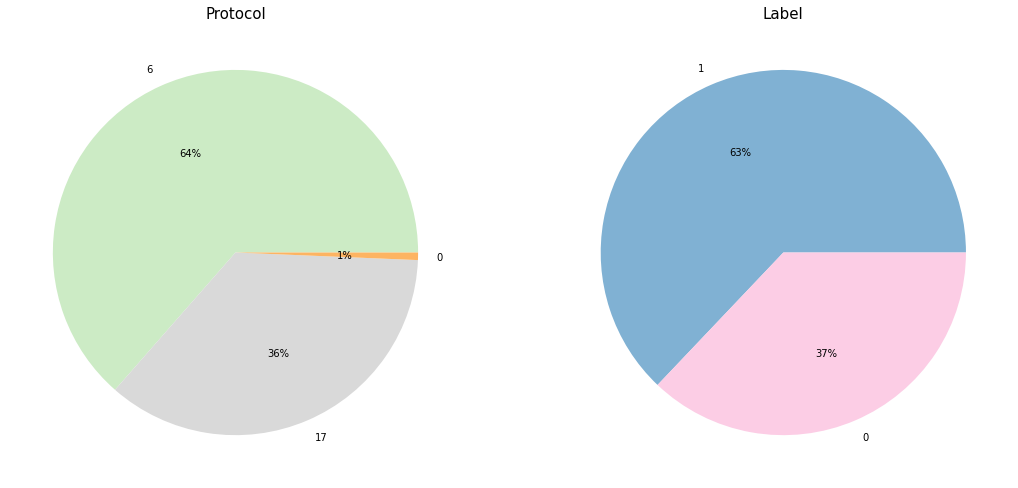

In [12]:
pie_plot(df_train, ['Protocol', 'Label'], 1, 2)

<a name="Preprocess"></a>
## 5.  Preprocess dataset

In [13]:
# Separate features and labels for classification
X = df_train.drop('Label', axis=1)
y = df_train['Label']

In [14]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [15]:
X.shape

(125170, 77)

In [16]:
# Split the data into train and validation sets
X_train, X_val1, y_train, y_val1 = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val1, y_val1, test_size=0.1, random_state=0)

In [17]:
# Separate features and labels for regression
X = df_train.drop('Label', axis=1)
y_reg = df_train['Label']

# Standardize the features for regression
scaler_reg = StandardScaler()
X_reg = scaler_reg.fit_transform(X)

# Split the data into train and validation sets for regression
X_train_reg, X_val1_reg, y_train_reg, y_val1_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=0)
X_val_reg, X_test_reg, y_val_reg, y_test_reg = train_test_split(X_val1_reg, y_val1_reg, test_size=0.1, random_state=0)

In [18]:
def evaluate_regression(model, name, X_train, X_test, y_train, y_test):
    train_rmse = mean_squared_error(y_train, model.predict(X_train), squared=False)
    test_rmse = mean_squared_error(y_test, model.predict(X_test), squared=False)

    print("Training RMSE " + str(name) + ": {:.4f}".format(train_rmse))
    print("Test RMSE " + str(name) + ": {:.4f}".format(test_rmse))


In [19]:
classification_evals = {}

def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(np.array(X_train)))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(np.array(X_test)))
    train_precision = metrics.precision_score(y_train, model.predict(np.array(X_train)))
    test_precision = metrics.precision_score(y_test, model.predict(np.array(X_test)))
    train_recall = metrics.recall_score(y_train, model.predict(np.array(X_train)))
    test_recall = metrics.recall_score(y_test, model.predict(np.array(X_test)))

    classification_evals[name] = {
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Train Precision': train_precision,
        'Test Precision': test_precision,
        'Train Recall': train_recall,
        'Test Recall': test_recall
    }

    print("Training Accuracy " + str(name) + ": {:.2f}".format(train_accuracy * 100))
    print("Test Accuracy " + str(name) + ": {:.2f}".format(test_accuracy * 100))
    print("Training Precision " + str(name) + ": {:.2f}".format(train_precision * 100))
    print("Test Precision " + str(name) + ": {:.2f}".format(test_precision * 100))
    print("Training Recall " + str(name) + ": {:.2f}".format(train_recall * 100))
    print("Test Recall " + str(name) + ": {:.2f}".format(test_recall * 100))

    # Plot the confusion matrix
    actual = y_test
    predicted = model.predict(np.array(X_test))
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['normal','attack'])

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.grid(False)
    cm_display.plot(ax=ax)


<a name="Modelling"></a>
## 6.  Model Building

### Logistic Regression

Training Accuracy Logistic Regression: 99.52
Test Accuracy Logistic Regression: 99.55
Training Precision Logistic Regression: 99.72
Test Precision Logistic Regression: 99.79
Training Recall Logistic Regression: 99.52
Test Recall Logistic Regression: 99.50


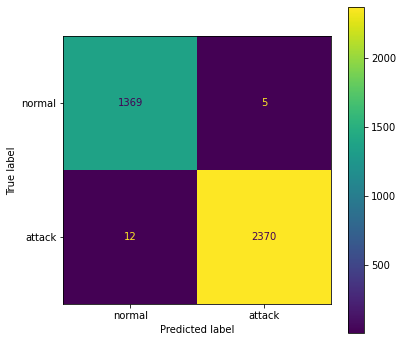

In [20]:
lr = LogisticRegression().fit(X_train, y_train)
evaluate_classification(lr, "Logistic Regression", X_train, X_test, y_train, y_test)

#### Knearest neighbors

Training Accuracy KNeighborsClassifier: 99.75
Test Accuracy KNeighborsClassifier: 99.79
Training Precision KNeighborsClassifier: 99.80
Test Precision KNeighborsClassifier: 99.92
Training Recall KNeighborsClassifier: 99.79
Test Recall KNeighborsClassifier: 99.75


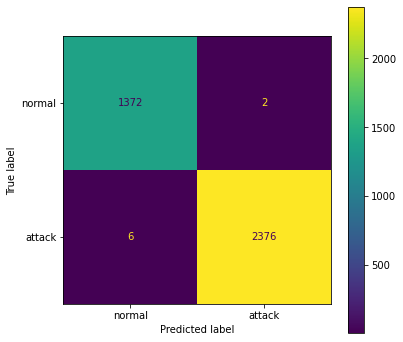

In [21]:
knn = KNeighborsClassifier(n_neighbors=20).fit(X_train, y_train)
evaluate_classification(knn, "KNeighborsClassifier", X_train, X_test, y_train, y_test)

### Naive Bayes

Training Accuracy GaussianNB: 98.55
Test Accuracy GaussianNB: 98.59
Training Precision GaussianNB: 98.31
Test Precision GaussianNB: 98.42
Training Recall GaussianNB: 99.40
Test Recall GaussianNB: 99.37


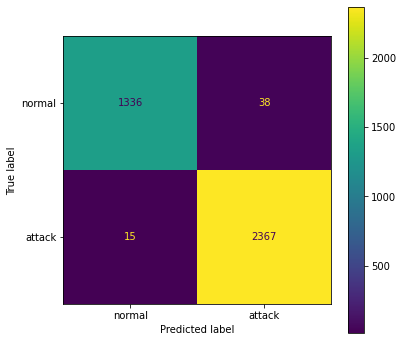

In [22]:
gnb = GaussianNB().fit(X_train, y_train)
evaluate_classification(gnb, "GaussianNB", X_train, X_test, y_train, y_test)

### SVM

Training Accuracy Linear SVC(LBasedImpl): 99.52
Test Accuracy Linear SVC(LBasedImpl): 99.57
Training Precision Linear SVC(LBasedImpl): 99.75
Test Precision Linear SVC(LBasedImpl): 99.87
Training Recall Linear SVC(LBasedImpl): 99.49
Test Recall Linear SVC(LBasedImpl): 99.45


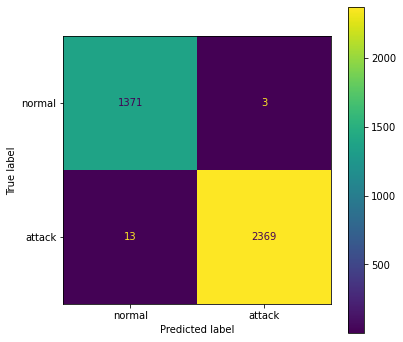

In [23]:
lin_svc = svm.LinearSVC().fit(X_train, y_train)
evaluate_classification(lin_svc, "Linear SVC(LBasedImpl)", X_train, X_test, y_train, y_test)

### Decision Tree

Training Accuracy DecisionTreeClassifier: 100.00
Test Accuracy DecisionTreeClassifier: 99.95
Training Precision DecisionTreeClassifier: 100.00
Test Precision DecisionTreeClassifier: 100.00
Training Recall DecisionTreeClassifier: 100.00
Test Recall DecisionTreeClassifier: 99.92


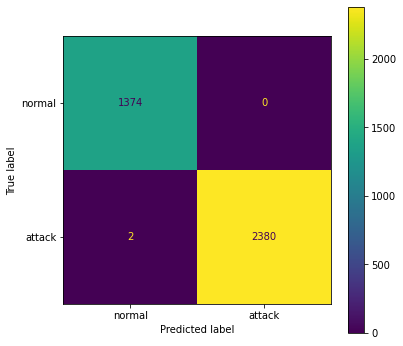

In [24]:
dt = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
tdt = DecisionTreeClassifier().fit(X_train, y_train)
evaluate_classification(tdt, "DecisionTreeClassifier", X_train, X_test, y_train, y_test)

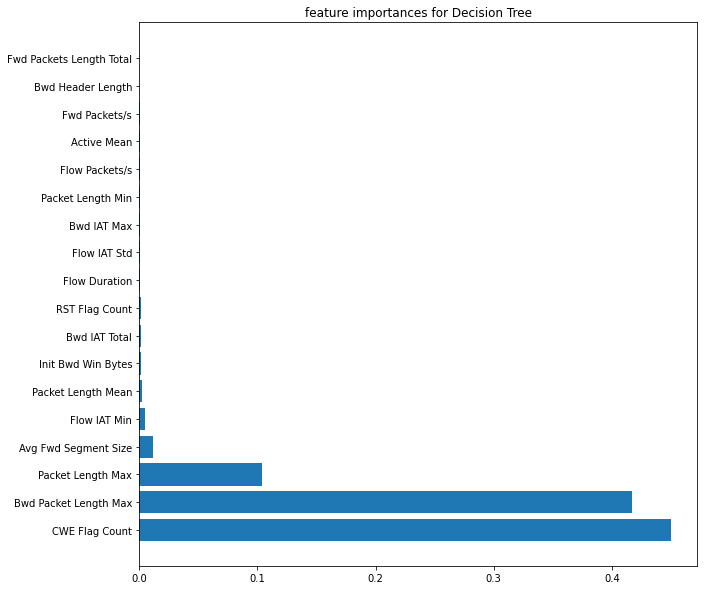

In [25]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)
    
    plt.figure(figsize=(10,10))
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importances for Decision Tree')
    plt.show()

features_names = df_train.drop(['Bwd Packets/s', 'Label'] , axis = 1)
f_importances(abs(tdt.feature_importances_), features_names, top=18)

[Text(0.5769230769230769, 0.875, 'X[10] <= -0.231\ngini = 0.467\nsamples = 87619\nvalue = [32506, 55113]'),
 Text(0.3076923076923077, 0.625, 'X[48] <= 0.905\ngini = 0.338\nsamples = 70172\nvalue = [15115, 55057]'),
 Text(0.15384615384615385, 0.375, 'X[38] <= -0.486\ngini = 0.088\nsamples = 57597\nvalue = [2664, 54933]'),
 Text(0.07692307692307693, 0.125, 'gini = 0.039\nsamples = 2340\nvalue = [2294, 46]'),
 Text(0.23076923076923078, 0.125, 'gini = 0.013\nsamples = 55257\nvalue = [370, 54887]'),
 Text(0.46153846153846156, 0.375, 'X[36] <= -0.329\ngini = 0.02\nsamples = 12575\nvalue = [12451, 124]'),
 Text(0.38461538461538464, 0.125, 'gini = 0.161\nsamples = 681\nvalue = [621, 60]'),
 Text(0.5384615384615384, 0.125, 'gini = 0.011\nsamples = 11894\nvalue = [11830, 64]'),
 Text(0.8461538461538461, 0.625, 'X[19] <= 2.637\ngini = 0.006\nsamples = 17447\nvalue = [17391, 56]'),
 Text(0.7692307692307693, 0.375, 'X[7] <= -0.096\ngini = 0.006\nsamples = 17445\nvalue = [17391, 54]'),
 Text(0.69230

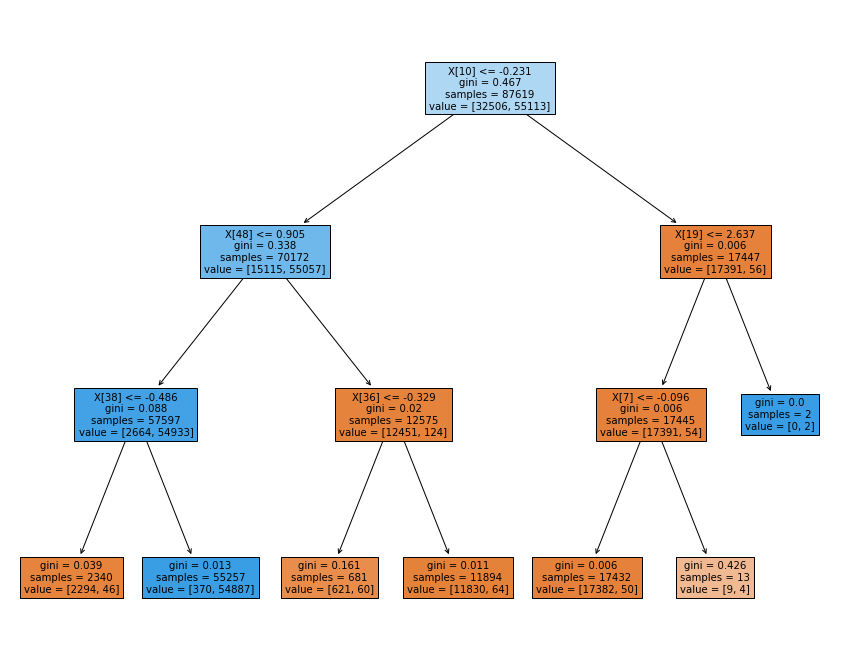

In [26]:
fig = plt.figure(figsize=(15,12))
tree.plot_tree(dt , filled=True)

## Random forest

Training Accuracy RandomForestClassifier: 100.00
Test Accuracy RandomForestClassifier: 99.95
Training Precision RandomForestClassifier: 100.00
Test Precision RandomForestClassifier: 100.00
Training Recall RandomForestClassifier: 100.00
Test Recall RandomForestClassifier: 99.92


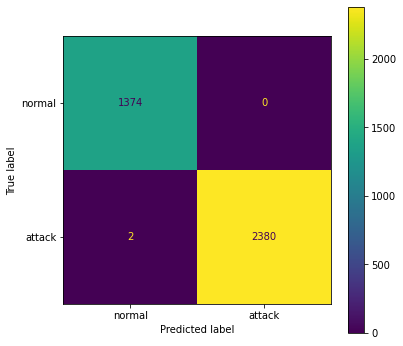

In [27]:
rf = RandomForestClassifier().fit(X_train, y_train)
evaluate_classification(rf, "RandomForestClassifier", X_train, X_test, y_train, y_test)

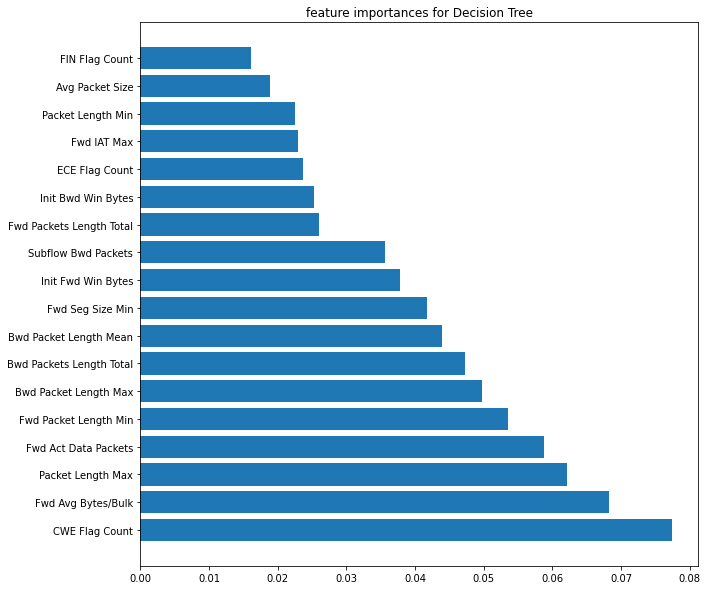

In [28]:
f_importances(abs(rf.feature_importances_), features_names, top=18)

### XGBOOST Regressor in order to predict threat level

In [29]:
# Train XGBoost regressor
xg_r = xgb.XGBRegressor(objective='reg:linear', n_estimators=20).fit(X_train_reg, y_train_reg)

[17:17:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [30]:
name = "XGBOOST"
train_error = metrics.mean_squared_error(y_train_reg, xg_r.predict(X_train_reg), squared=False)
test_error = metrics.mean_squared_error(y_test_reg, xg_r.predict(X_test_reg), squared=False)
print("Training Error " + str(name) + ": {:.4f}".format(train_error))
print("Test Error " + str(name) + ": {:.4f}".format(test_error))

Training Error XGBOOST: 0.0213
Test Error XGBOOST: 0.0242


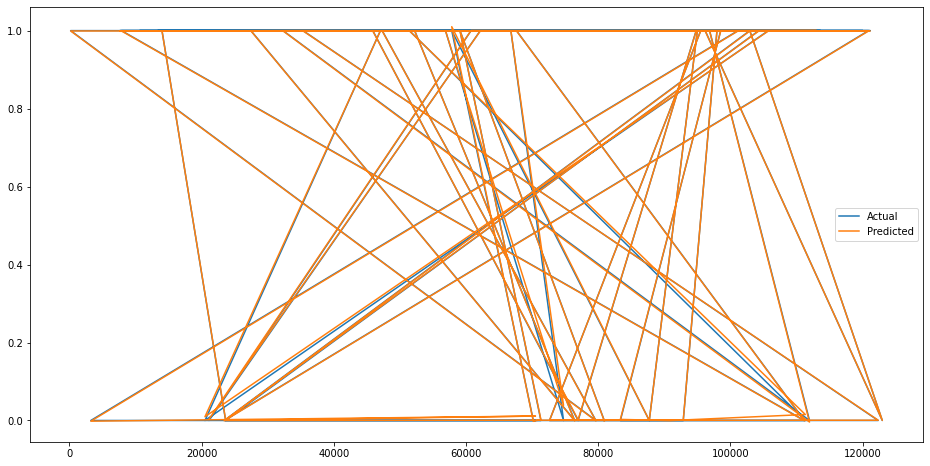

In [31]:
y_pred = xg_r.predict(X_test_reg)
df = pd.DataFrame({"Y_test": y_test_reg, "Y_pred": y_pred})
plt.figure(figsize=(16, 8))
plt.plot(df[:80])
plt.legend(['Actual', 'Predicted'])
plt.show()

### Bagging Ensemble

In [32]:

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.model_selection import train_test_split

In [33]:
# Create base classifiers for the ensemble
base_classifier_dt = DecisionTreeClassifier()
base_classifier_lr = LogisticRegression()
base_classifier_knn = KNeighborsClassifier(n_neighbors=20)
base_classifier_nb = GaussianNB()
base_classifier_svc = CalibratedClassifierCV(LinearSVC())
base_classifier_xgb = xgb.XGBClassifier()

In [34]:
# Create the bagging ensemble
bagging_classifier = BaggingClassifier(base_classifier_dt, n_estimators=20)

In [35]:
# Fit the bagging ensemble on the training data
bagging_classifier.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=20)

Training Accuracy Bagging Ensemble: 100.00
Test Accuracy Bagging Ensemble: 99.95
Training Precision Bagging Ensemble: 100.00
Test Precision Bagging Ensemble: 100.00
Training Recall Bagging Ensemble: 99.99
Test Recall Bagging Ensemble: 99.92


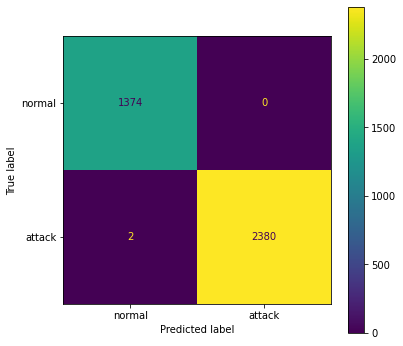

In [36]:
# Evaluate the bagging ensemble
evaluate_classification(bagging_classifier, "Bagging Ensemble", X_train, X_test, y_train, y_test)


### Voting Ensemble

In [37]:
voting_classifier = VotingClassifier(
    estimators=[
        ('lr', base_classifier_lr),
        ('knn', base_classifier_knn),
        ('nb', base_classifier_nb),
        ('svc', base_classifier_svc),
        ('xgb', base_classifier_xgb)
    ],
    voting='soft'  # Use 'soft' voting for probabilities, or 'hard' for majority voting
)

In [38]:
# Fit the voting ensemble on the training data
voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('knn', KNeighborsClassifier(n_neighbors=20)),
                             ('nb', GaussianNB()),
                             ('svc',
                              CalibratedClassifierCV(base_estimator=LinearSVC())),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_cat...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None,
                                            reg_alpha=None, reg_lambda=None, ...))],
                 voting='soft')

Training Accuracy Voting Ensemble: 99.67
Test Accuracy Voting Ensemble: 99.65
Training Precision Voting Ensemble: 99.89
Test Precision Voting Ensemble: 99.96
Training Recall Voting Ensemble: 99.58
Test Recall Voting Ensemble: 99.50


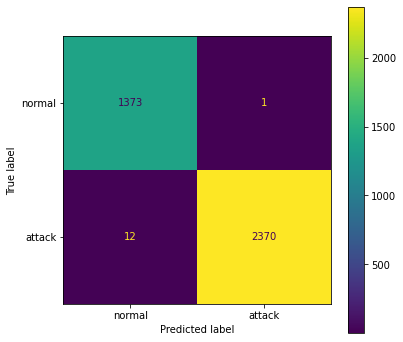

In [39]:
# Evaluate the voting ensemble
evaluate_classification(voting_classifier, "Voting Ensemble", X_train, X_test, y_train, y_test)

### XGB Classification

In [40]:
base_classifier_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

Training Accuracy XGBoost: 100.00
Test Accuracy XGBoost: 99.97
Training Precision XGBoost: 100.00
Test Precision XGBoost: 100.00
Training Recall XGBoost: 100.00
Test Recall XGBoost: 99.96


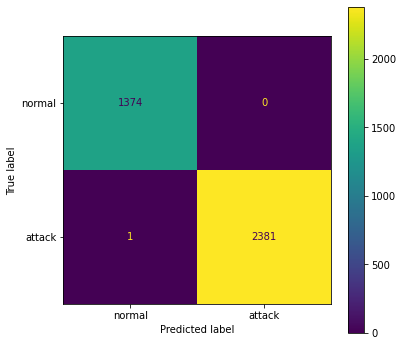

In [41]:
evaluate_classification(base_classifier_xgb, "XGBoost", X_train, X_test, y_train, y_test)

## Neural Networks

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

In [43]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4992      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               66048     
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               6

In [45]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [46]:
# Assuming you have defined the Keras model as 'model'
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [47]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Epoch 1/10
2739/2739 [==============================] - 7679s 44ms/step - loss: 0.1288 - accuracy: 0.9894 - val_loss: 0.0637 - val_accuracy: 0.9949
Epoch 2/10
2739/2739 [==============================] - 65s 24ms/step - loss: 0.0546 - accuracy: 0.9951 - val_loss: 0.0393 - val_accuracy: 0.9957
Epoch 3/10
2739/2739 [==============================] - 62s 23ms/step - loss: 0.0407 - accuracy: 0.9952 - val_loss: 0.0318 - val_accuracy: 0.9960
Epoch 4/10
2739/2739 [==============================] - 72s 26ms/step - loss: 0.0375 - accuracy: 0.9955 - val_loss: 0.0304 - val_accuracy: 0.9965
Epoch 5/10
2739/2739 [==============================] - 69s 25ms/step - loss: 0.0367 - accuracy: 0.9957 - val_loss: 0.0285 - val_accuracy: 0.9965
Epoch 6/10
2739/2739 [==============================] - 70s 26ms/step - loss: 0.0352 - accuracy: 0.9958 - val_loss: 0.0276 - val_accuracy: 0.9965
Epoch 7/10
2739/2739 [==============================] - 70s 26ms/step - loss: 0.0326 - accuracy: 0.9960 - val_loss: 0.0279

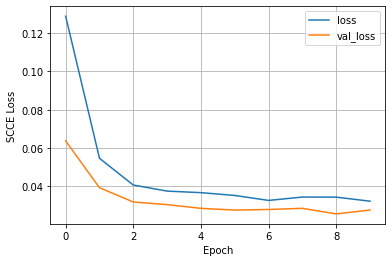

In [48]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('SCCE Loss')
plt.legend()
plt.grid(True)

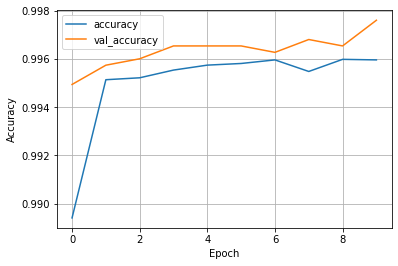

In [49]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

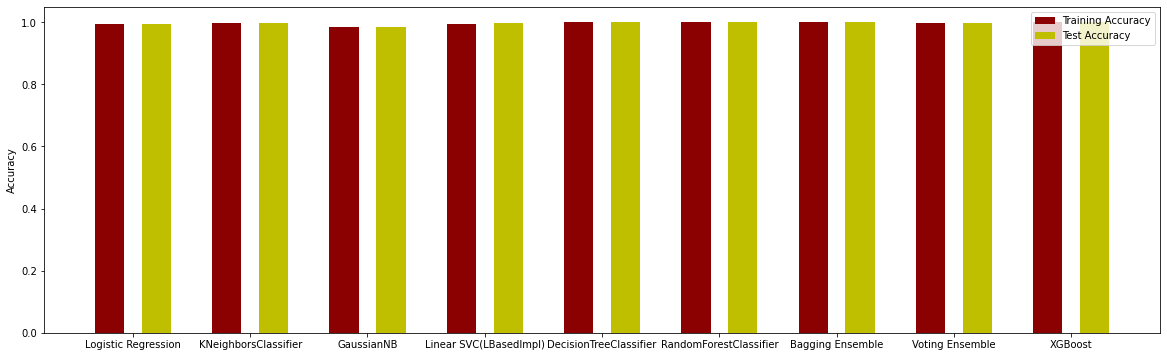

In [50]:
keys = list(classification_evals.keys())
values = list(classification_evals.values())
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(np.arange(len(keys)) - 0.2, [value['Train Accuracy'] for value in values], color='darkred', width=0.25, align='center')
ax.bar(np.arange(len(keys)) + 0.2, [value['Test Accuracy'] for value in values], color='y', width=0.25, align='center')
ax.legend(["Training Accuracy", "Test Accuracy"])
ax.set_xticklabels(keys)
ax.set_xticks(np.arange(len(keys)))
plt.ylabel("Accuracy")
plt.show()

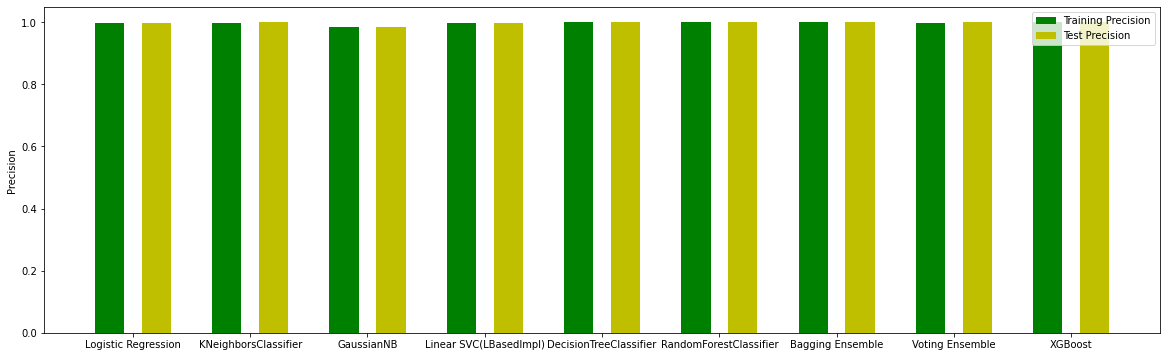

In [51]:
keys = list(classification_evals.keys())
values = list(classification_evals.values())
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(np.arange(len(keys)) - 0.2, [value['Train Precision'] for value in values], color='g', width=0.25, align='center')
ax.bar(np.arange(len(keys)) + 0.2, [value['Test Precision'] for value in values], color='y', width=0.25, align='center')
ax.legend(["Training Precision", "Test Precision"])
ax.set_xticklabels(keys)
ax.set_xticks(np.arange(len(keys)))
plt.ylabel("Precision")
plt.show()

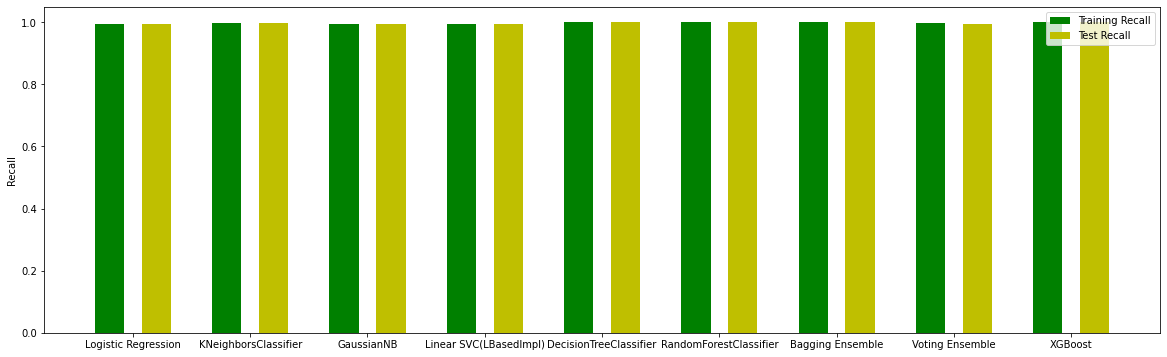

In [52]:
keys = list(classification_evals.keys())
values = list(classification_evals.values())
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(np.arange(len(keys)) - 0.2, [value['Train Recall'] for value in values], color='g', width=0.25, align='center')
ax.bar(np.arange(len(keys)) + 0.2, [value['Test Recall'] for value in values], color='y', width=0.25, align='center')
ax.legend(["Training Recall", "Test Recall"])
ax.set_xticklabels(keys)
ax.set_xticks(np.arange(len(keys)))
plt.ylabel("Recall")
plt.show()